In [1]:
from LIMxCMBL.experiments import *

In [2]:
n_bins = 100


In [3]:
for experiment in experiments:
    print(experiment)

CCAT-prime
COMAP
SPHEREx
HETDEX
CHIME


In [4]:
log_ymin = np.log10(ells[0])
log_ymax = np.log10(ells[-1])


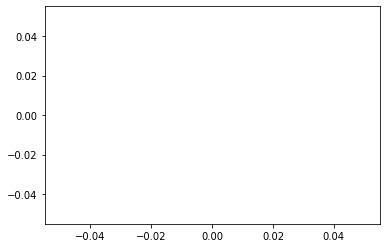

In [5]:
import matplotlib.pyplot as plt
from matplotlib import colors

plt.plot()
plt.rcParams.update({
    "text.usetex": True,
    "font.size": "11",
    "font.family" : "11",
    'hatch.linewidth':0.1
})


In [6]:
Lambdas[18], Lambdas[24]

(0.01, 0.1)

In [7]:
e_order = ['CHIME',
          'HETDEX',
          'COMAP',
          'CCAT-prime',
          'SPHEREx']

2.0446626032894333 270.0
20.784609690826528 216000.0
227.68399153212331 4238.676081055709
127.27922061357856 50864.1129726685
24 60 CCAT-prime
25.45584412271571 108000.0


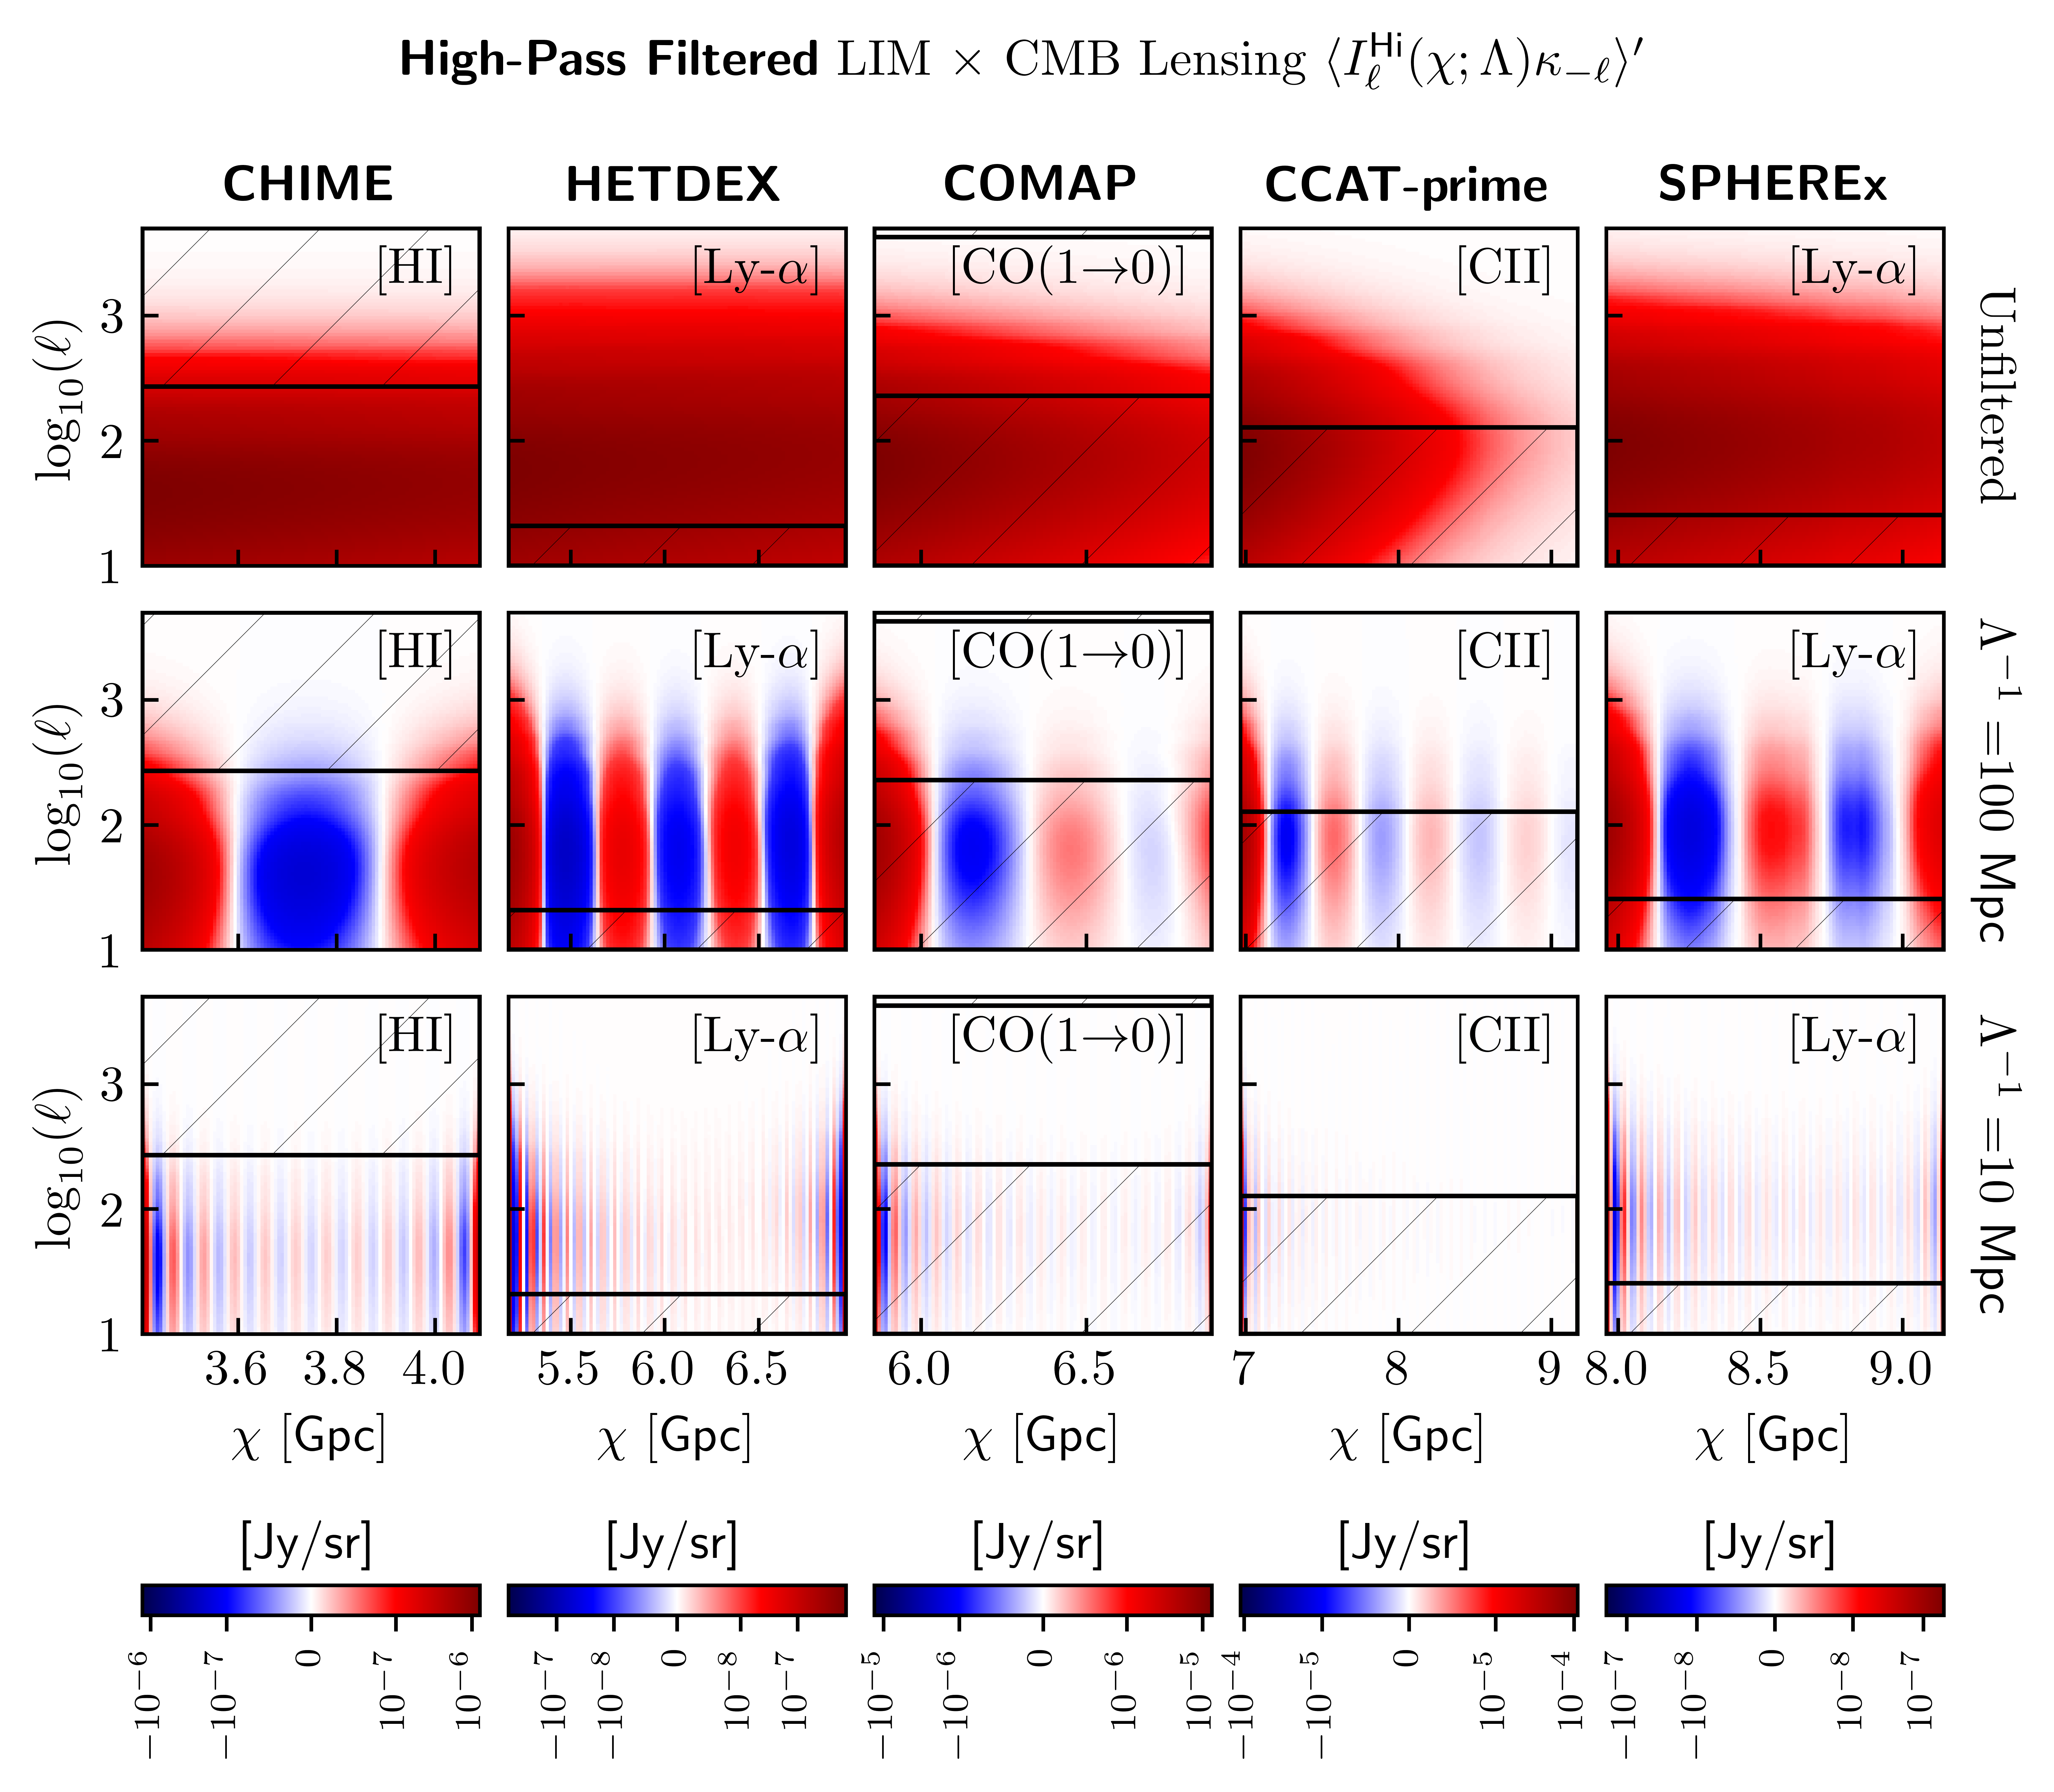

In [8]:
fig, meta_axs = plt.subplots(nrows=3, ncols=5, 
                             figsize = (5.8, 3.65), facecolor = 'w', dpi = 1000,
                            sharex = 'col',
                            sharey = 'row')
plt.tight_layout(pad = 0.0)
for ax in meta_axs.flatten():
    ax.tick_params(axis='both', direction='in')

    
outside = [1]
for e_idx in range(5):

    experiment = e_order[e_idx]
    axs = meta_axs[:,e_idx]

    zmin = experiments[experiment]['zmin']
    zmax = experiments[experiment]['zmax']
    line_str = experiments[experiment]['line_str']

        
    Omega_field  =  experiments[experiment]['Omega_field'].to(u.rad**2) # rad^2
    survey_ell_fund = np.array(np.sqrt((2*np.pi)**2/Omega_field))
    
    ell_max_survey = np.sqrt((np.pi)**2 / experiments[experiment]['Omega_pix'].to(u.rad**2))
    ell_max_survey = np.array(ell_max_survey)
    print(survey_ell_fund, ell_max_survey)

    chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
    chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))
    
    
    chi_bin_edges = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_bins + 1)
    chi_bin_centers = (chi_bin_edges[1:] + chi_bin_edges[:-1])/2
    dchi_binned = np.mean(np.diff(chi_bin_edges))
    
    I_kappa_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/Ik_'
    I_kappa_fname +='zmin_%.5f_zmax_%.5f_quad_next_%d.npy'%(zmin, 
                                                            zmax, 
                                                            1000)

    I_kappa_unbinned = np.load(I_kappa_fname)
    I_kappa = np.zeros((len(ells), n_bins))
    external_chis = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), 1000)
    for i, (l1, r1) in enumerate(zip(chi_bin_edges, chi_bin_edges[1:])):
        idx1 = np.where((external_chis > l1) & (external_chis <= r1))[0]
        I_kappa[:,i] = (np.sum(I_kappa_unbinned[:,idx1[0]:idx1[-1]+1,], 
                             axis=(1)) / len(idx1))

    I_kappa *= 1000 #kJy -> Jy
    vb = np.max(np.abs(I_kappa))
    
    lin_factor = 1
    log10vb = np.log10(vb)
    linthresh = 10**(int(log10vb)-2)
    vminmax = 10**(log10vb)
    
    norm = colors.SymLogNorm(linthresh=linthresh, 
                             linscale=lin_factor,
                             vmin=-vminmax, 
                             vmax=vminmax, 
                             base=10)

    def plot(ax, data, vminmax):
        im = ax.imshow(data, 
                       origin='lower',
                       cmap = 'seismic',
                       norm = norm,
#                        vmin = -vb,
#                        vmax=vb,
                  aspect = (chimin-chimax) / 1000 / (log_ymin - log_ymax),
                  extent=[chimin/1000, chimax/1000, log_ymin, log_ymax,])

        return im


    

    
        
        
    im = plot(axs[0], I_kappa, vb, )

    ax_idx = 1
    for Lambda_idx in [18, 24]:
        Lambda = Lambdas[Lambda_idx]

        IHi_kappa = np.zeros((100, n_bins))

        for curr_bin in range(n_bins):
            try:
                oup_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/'
                oup_fname += '%s_IHik_zmin_%.1f_zmax_%.1f_idx_%d_dblquad_n_bins_%d_curr_%d.npy'%(line_str,
                                                                                                 zmin, 
                                                                                                 zmax, 
                                                                                                 Lambda_idx, 
                                                                                                 n_bins, 
                                                                                                 curr_bin)
                IHi_kappa[:,curr_bin] = np.load(oup_fname)
            except:
                print(Lambda_idx, curr_bin, experiment)
        IHi_kappa *= 1000 #kJy -> Jy

        im = plot(axs[ax_idx], IHi_kappa.astype(np.float64), vb)
        ax_idx+=1

        
    if(line_str == 'Lya'):
        line_str = r'Ly-$\alpha$'
    if(line_str == 'CO'):
        line_str = r'CO(1$\rightarrow$0)'
        
        
        
    axs[0].set_title(r'\textsf{\textbf{%s}}'%(experiment), fontsize = 11)
    for i in range(3):
        axs[i].text(0.95, 0.95, '[%s]'%(line_str), transform=axs[i].transAxes, 
                    ha='right', va='top')

    if(np.log10(survey_ell_fund) > 1 and np.log10(survey_ell_fund) < np.log10(max(ells))):
        for ax_idx in range(3):
            axs[ax_idx].fill_between([chimin/1000, chimax/1000], 
                                     [1, 1],
                                     [np.log10(survey_ell_fund), 
                                      np.log10(survey_ell_fund)],
                                    facecolor="None", hatch='/',
                                     linewidth=1,
                                     edgecolor="k")
    elif(np.log10(survey_ell_fund) > np.log10(max(ells))):
        for ax_idx in range(3):
            axs[ax_idx].fill_between([chimin/1000, chimax/1000], 
                                     [1, 1],
                                     [np.log10(max(ells)), 
                                      np.log10(max(ells))],
                                     facecolor="None", hatch='/',
                                     linewidth=1,
                                     edgecolor="k")

    if(ell_max_survey < max(ells)):
        for ax_idx in range(3):
            axs[ax_idx].fill_between([chimin/1000, chimax/1000], 
                                     [np.log10(5000), np.log10(5000)],
                                     [np.log10(ell_max_survey), 
                                      np.log10(ell_max_survey)],
                                    facecolor="None", hatch='/',
                                     linewidth=1,
                                     edgecolor="k")

    plt_left = plt.rcParams['figure.subplot.left']
    plt_right = plt.rcParams['figure.subplot.right']

    _bbox = axs[-1].get_position()
    dy = _bbox.ymax - _bbox.ymin
    dx = _bbox.xmax - _bbox.xmin
    cbar_ax = fig.add_axes([_bbox.xmin, 
                            _bbox.ymin - 5/6*dy, 
                            dx, 
                            0.025])  # [left, bottom, width, height]

    
    
    cbar = fig.colorbar(im, cax=cbar_ax,
                       orientation='horizontal', )#label=r'\sf[kJy/sr]')
    cbar.ax.tick_params(labelsize=8, rotation = 90)
    cbar.ax.set_title(r"\sf[Jy/sr]", fontsize = 11)

    axs[-1].set_xlabel(r'$\chi$ [{\sf Gpc}]')

    if(e_idx > 0):
        continue
    for i in range(3):
        axs[i].set_ylabel(r'$\log_{10}(\ell)$')
        

        

meta_axs[0, -1].text(1.08, 0.5, r'Unfiltered', 
                     transform=meta_axs[0, -1].transAxes, 
                     ha='left', va='center',
                    rotation=-90)

meta_axs[1, -1].text(1.08, 0.5, r'$\Lambda^{-1}=$100\ {\sf Mpc}', 
                     transform=meta_axs[1, -1].transAxes, 
                     ha='left', va='center',
                    rotation=-90)


meta_axs[2, -1].text(1.08, 0.5,  r'$\Lambda^{-1}=$10\ {\sf Mpc}', 
                     transform=meta_axs[2, -1].transAxes, 
                     ha='left', va='center',
                    rotation=-90)

meta_axs[2, -1].set_xticks([8,8.5,9])
meta_axs[2, 0].set_xticks([3.6,3.8, 4])



plt_left = plt.rcParams['figure.subplot.left']
plt_right = plt.rcParams['figure.subplot.right']
plt_cntr = (plt_left + plt_right) / 2


fig.text(plt_cntr, 1.1, r"\textbf{\textsf{High-Pass Filtered}} LIM $\times$ CMB Lensing $\langle I_{ \ell}^{\sf Hi}(\chi;\Lambda) \kappa_{- \ell}\rangle'$",
         ha='center', 
         va='bottom', 
        fontsize=11)


plt.savefig('figures/013.000.IHi_kappa.pdf', bbox_inches='tight')